In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy as unp

In [3]:
#eq of line
def LS_fit_ymxb(data_x,data_y,SDM_data):
    ystd = 0 #calculation of each of the sums
    xstd = 0
    xystd = 0
    x2std = 0
    std2 = 0
    for x,y,i_std in zip(data_x,data_y,SDM_data):
        ystd += y/i_std**2
        xstd += x/i_std**2
        xystd += x*y/i_std**2
        x2std += x**2/i_std**2
        std2 += 1/i_std**2
  #now all the sums have formed just have to find a,b,delt
    matrix_a = np.array([[ystd, xstd],[xystd, x2std]])
    matrix_b = np.array([[std2, ystd],[xstd, xystd]])
    matrix_delta = np.array([[std2, xstd],[xstd, x2std]])
    delta = np.linalg.det(matrix_delta)
    a = (1/delta) * np.linalg.det(matrix_a)
    b = (1/delta) * np.linalg.det(matrix_b)
    unc_a = ((1/delta) * x2std)**.5
    unc_b = ((1/delta) * std2)**.5
    mxslope = xystd/x2std
    mxslope_unc = (x2std)**-.5
    #print(f'for y=bx+a, b: {b} +- {unc_b}, a: {a} +- {unc_a} and for y=bx, b: {mxslope} +- {mxslope_unc}')
    return [b,unc_b,a,unc_a,mxslope,mxslope_unc]

def chi_squared_of_y_ax_plus_b(slope,y_intercept,slope2,data_x,data_y,SDM,DF1,DF2):
    sum_chi = 0
    sum_chi_for_ybx = 0
    for x,y,i_SDM in zip(data_x,data_y,SDM):
        sum_chi += ((y - y_intercept - slope*x)/i_SDM)**2
        sum_chi_for_ybx += ((y - slope2*x)/i_SDM)**2
    return [sum_chi, sum_chi/DF1, sum_chi_for_ybx, sum_chi_for_ybx/DF2]

def ssd(sample):
    mean_sample = np.mean(sample)
    N = len(sample)
    sum_sample = 0
    for i in sample:
        sum_sample += (i - mean_sample)**2
    sample_std = ((sum_sample)/(N-1))**0.5
    return sample_std

def wMean_wStd(mean_list, std_list): #weighted mean based off of the standard deviations
    sum_top = 0
    sum_bottom = 0
    for i,j in zip(mean_list,std_list):
        sum_top += i/j**2
        sum_bottom += 1/j**2
    weighted_mean = sum_top/sum_bottom
    weighted_std = (1/sum_bottom)**0.5
    return  (weighted_mean, weighted_std)

def chi_squared(mean_samples_list,std_samples_list,weighted_mean,deg_of_freedom): #for pi lab requires list of means and the total mean of those means
    chi_squared = 0
    for i,j in zip(mean_samples_list,std_samples_list):
        chi_squared += (i - weighted_mean)**2/j**2
    reduced_chi_squared = chi_squared/deg_of_freedom
    return (chi_squared, reduced_chi_squared)

In [4]:
#get data from ods file

df = pd.read_excel("442 pendulum lab.ods", engine="odf")
df2 = pd.read_excel("442 pendulum lab.ods", engine="odf", sheet_name=1)

#Period Experiments in data
ten_one = np.array(df['ten_one'].to_list())
ten_ten = np.array([np.array(df[f"Run{i}"].to_list()) for i in range(1,10)])
length_10 = np.array(df['Lengths (Day 1) (mm)'].to_list())/1000

ten_hundred = np.array(df['ten_hundred'].to_list())
lengths_hund = np.array(df['Length (Day 2) (mm)'].to_list()[0])

#amplitude data
amp_angles = [60,55,45,35,25,15]
amp_period = np.array([np.array(df2[f"{i} degrees"].to_list()) for i in amp_angles])
amp_period2 = np.array([amp_period[i][:5] for i in range(len(amp_period))])
amp_length = np.array(df2['New L'].to_list())/39.37
amp_drag = np.array([df2[f"ADr {i}"][0] for i in amp_angles])

#exta_info in data
extra_info = np.array(df['Extra Info'].to_list())
names = np.array(df['Name'].to_list())

mask1 = extra_info != None
mask2 = names != 'nan'

dict_extras = dict(zip(names[mask2],extra_info[mask1]))

#print(np.array([amp_period[i][:5] for i in range(len(amp_period))]))

In [5]:
#GET THEORETICAL PERIOD USING LENGTHS
#print(dict_extras)

def get_period(lengths,hook,g):
    m_line = float(np.mean(lengths))
    if len([lengths]) == 1:
        ssd_line = 0.003
    else:
        ssd_line = ssd(lengths)/np.sqrt(len(lengths))
        
    lines = ufloat(m_line, ssd_line)
    #print(f'Length: {lines*100}')
    hooks = ufloat((hook/39.37)/2,(hook/39.37)/2)
    #print(f'Hook: {hooks*100}')
    radius = ufloat(0.01888,0.00025) 
    #print(f'Radius: {radius*100}')
    L = radius + hooks + lines
    P = 2*np.pi*(L/g)**(0.5)
    P_nom = np.round(P.n,3)
    P_std = np.round(P.s,3)
    P_round = ufloat(P_nom,P_std)
    return P_round

acc_T = get_period(length_10, dict_extras['hook length(inch)'], dict_extras['g (m/s^2)'])
acc_T_hund = get_period(lengths_hund/1000, dict_extras['hook length(inch)'], dict_extras['g (m/s^2)'])
amp_T = get_period(amp_length, dict_extras['hook length(inch)'], dict_extras['g (m/s^2)'])

def get_damp_period(lengths):
    c=0.0018
    g = dict_extras['g (m/s^2)']
    
    m_line = float(np.mean(lengths))
    ssd_line = ssd(lengths)/np.sqrt(len(lengths))
    line = ufloat(m_line, ssd_line)
    
    hook = dict_extras['hook length(inch)']
    hooks = ufloat((hook/39.37)/2,(hook/39.37)/2)
    
    radius = ufloat(0.01888,0.00025)
    m = ufloat(315.76, 0.01)/1000
    
    L = radius + hooks + line
    T = 2 * np.pi / (g/L + (c/(2*m))**2)**0.5

    return T

print(acc_T)
#print(get_damp_period(length_10))

#physical pendulum calculation
def get_phys_damp(lengths):
    c=0.0018
    g = dict_extras['g (m/s^2)']
    hook = dict_extras['hook length(inch)']
    hooks = ufloat((hook/39.37)/2,(hook/39.37)/2)
    
    Rline = 0.00014 #meters
    
    mline = 0.12575/1000 #kg
    mbob = ufloat(315.76, 0.01)/1000
    
    mean_line = float(np.mean(lengths))
    ssd_line = ssd(lengths)/np.sqrt(len(lengths))
    line = ufloat(mean_line, ssd_line)
    
    radius = ufloat(0.01888,0.00025)
    L = radius + hooks + line
    
    Mtot = mline + mbob
    line_l = line/2
    Lcm = (mbob*L + mline*line_l)/(Mtot)

    Icm = 1/3*mline*line_l**2 + (2/5)*mbob*(radius)**2 + mbob*(L)**2

    phys_factor = (Icm / (Mtot*g*Lcm))**(-1)
    
    T = 2 * np.pi / (phys_factor + (c/(2*mbob))**2)**0.5
    
    return T

print(np.mean(amp_period2[-1]), ssd(amp_period2[-1])/np.sqrt(len(amp_period2[-1])))
print(amp_T.n)
print(get_damp_period(amp_length).n)
print(get_phys_damp(amp_length).n)

print(acc_T_hund)

2.758+/-0.004
2.4116 0.005662155066756779
2.416
2.4164552962456316
2.4163394253690833
2.760+/-0.004


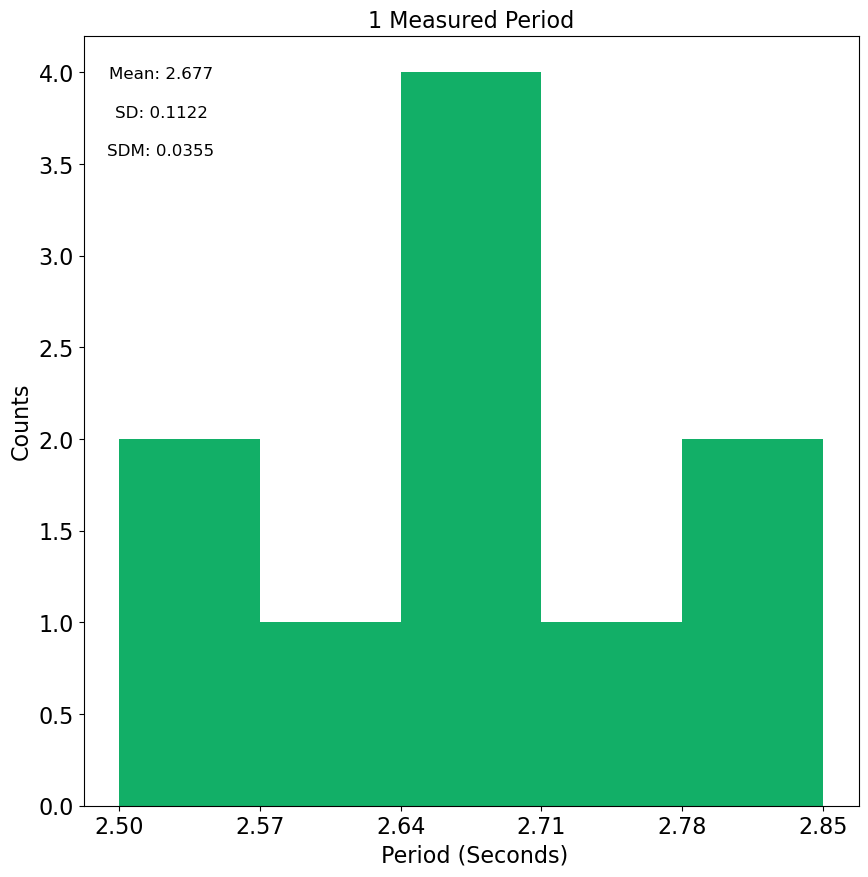

In [19]:
#EXPERIMENTAL VALUES
#TEN ONE

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

n_bins2=5
bin_range = np.linspace(min(ten_one),max(ten_one), 5+1)
n, bins, pathces = plt.hist(ten_one, bin_range, color='#12af67')

plt.xticks(bin_range)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.text(0.1, 0.95, f'Mean: {np.round(np.mean(ten_one),3)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.1, 0.9, f'SD: {np.round(ssd(ten_one),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.1, 0.85, f'SDM: {np.round(ssd(ten_one)/np.sqrt(len(ten_one)),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.title('1 Measured Period')
plt.xlabel(' Period (Seconds)')
plt.ylabel('Counts', fontsize=BIGGER_SIZE)
plt.show()


13.26384057321424


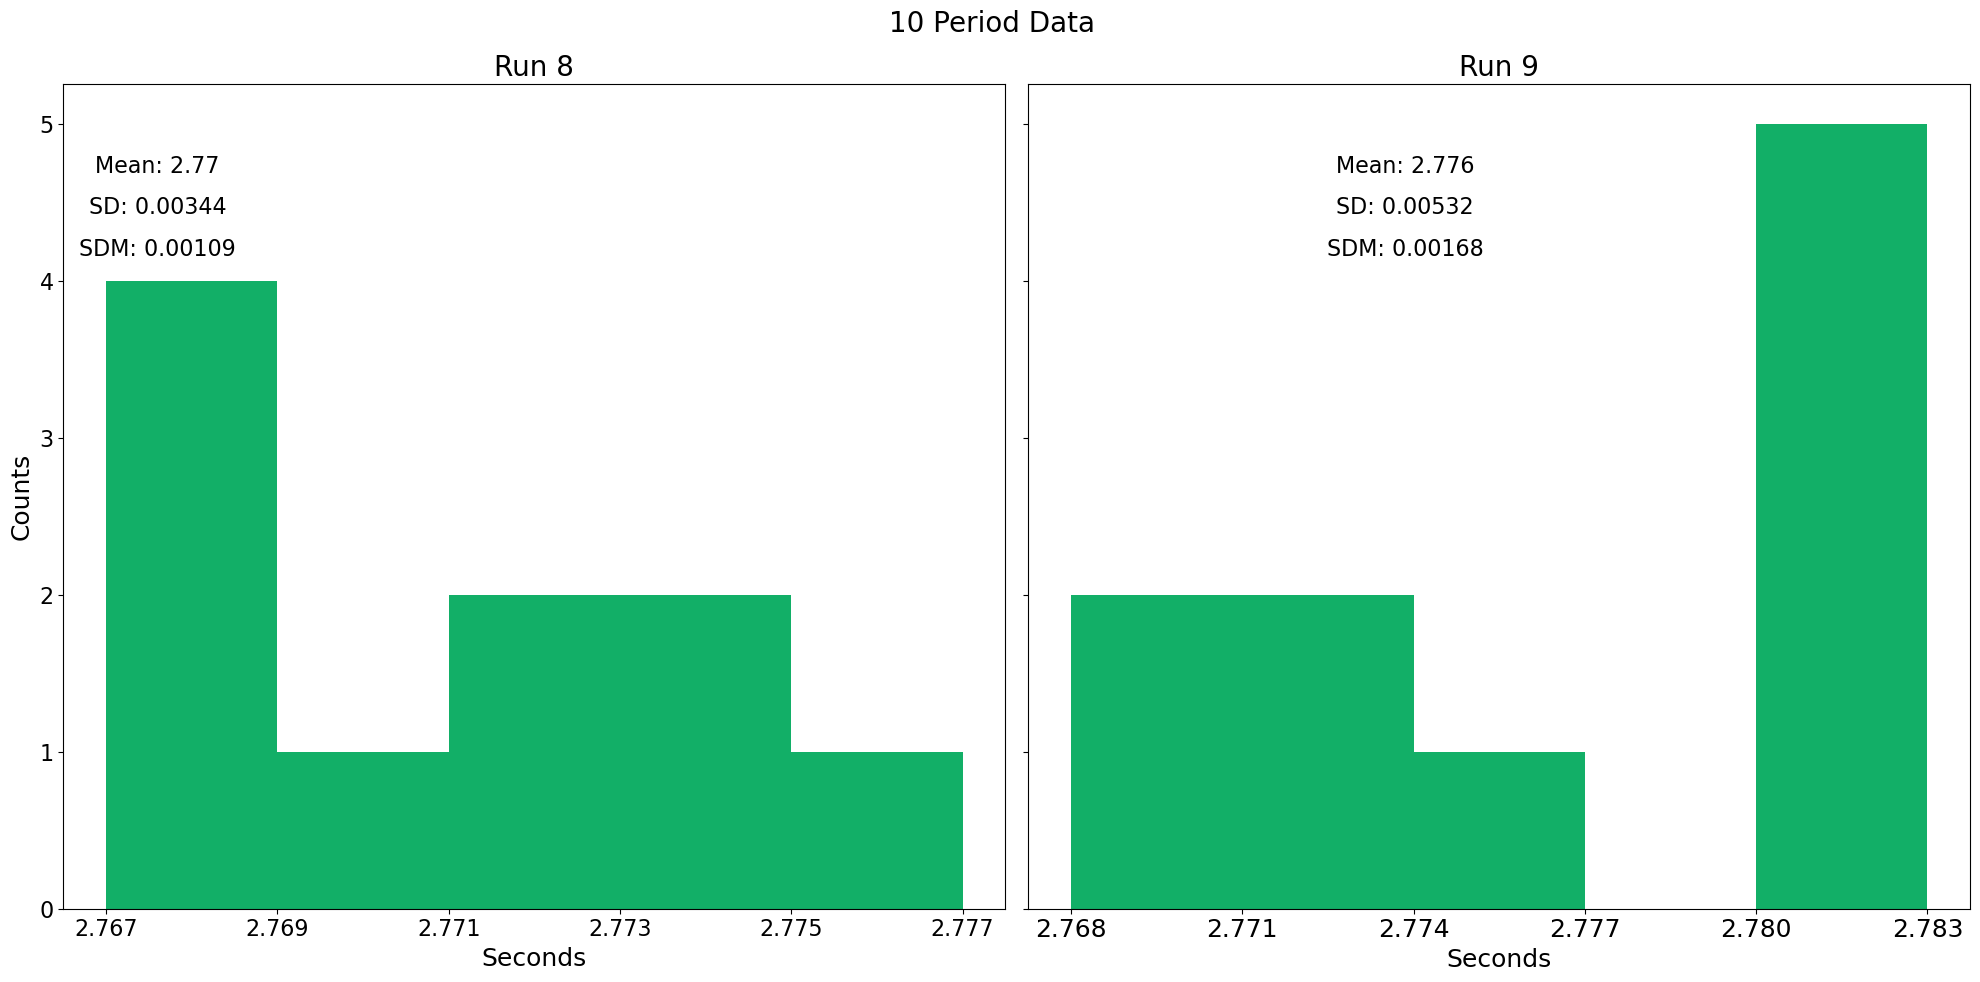

In [39]:
#EXPERIMENTAL VALUES 
#TEN TEN
#plot histograms SEPERATED
#run two outlier, number of standard deviations from the mean
min_period = min(ten_ten[1])
ten_mean = np.mean(ten_ten[1][ten_ten[1] != min_period])
ten_ssd = ssd(ten_ten[1][ten_ten[1] != min_period])
n_sd = (ten_mean - min_period)/ten_ssd
print(n_sd) # 13 standard deviations from the mean for this outlier, can safely remove

n_bins = 5
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10) ,layout='tight')

#In the following example, the format specifier is {x:9<5.1f} where 9 is the fill character 
#(instead of 0 so as to make the example more clear), < aligns numbers to the left, 5 is the number of characters 
#(digits + decimal point) that remains constant by adding the fill value to the right of the precision limit 
#of .1 for the fixed-point notation f
#print(ten_ten[-1][ten_ten[-1]>min_period])
    
ten_ten_filt = [ten_ten[i][ten_ten[i] != min_period] for i in range(len(ten_ten))]

for i in range(len(ten_ten)):
    #make histogram
    #4 #7
    if i==7:
        if i+1 == 2:
            n_bins = 5
        else:
            n_bins = 5
        axs[0].hist(ten_ten_filt[i], bins=n_bins, color='#12af67')
        #write SD and Mean
        run_mean = np.round(np.mean(ten_ten_filt[i]),3)
        run_sd = np.round(ssd(ten_ten_filt[i]),5)

        axs[0].text(0.1, .9, f'Mean: {run_mean}', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=16)
        axs[0].text(0.1, .85, f'SD: {run_sd}', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=16)
        axs[0].text(0.1, .80, f'SDM: {np.round(run_sd/np.sqrt(len(ten_ten_filt[i])),5)}', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=16)

        #sublot titles
        axs[0].set_title(f'Run {i+1}', fontdict={'fontsize':20})
        #format x-axis
        x_max = np.round(np.max(ten_ten_filt[i]),3)
        x_min = np.round(np.min(ten_ten_filt[i]),3)
        axs[0].set_xticks(np.linspace(x_min, x_max, np.round(int(n_bins)+1,0)))
        plt.setp(axs[0].get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=16)

        axs[0].xaxis.set_major_formatter('{x:9<5.3f}')

    if i==8:
        if i+1 == 2:
            n_bins = 5
        else:
            n_bins = 5
        axs[1].hist(ten_ten_filt[i], bins=n_bins, color='#12af67')
        #write SD and Mean
        run_mean = np.round(np.mean(ten_ten_filt[i]),3)
        run_sd = np.round(ssd(ten_ten_filt[i]),5)
        axs[1].text(0.4, .9, f'Mean: {run_mean}', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=16)
        axs[1].text(0.4, .85, f'SD: {run_sd}', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=16)
        axs[1].text(0.4, .80, f'SDM: {np.round(run_sd/np.sqrt(len(ten_ten_filt[i])),5)}', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=16)

        #sublot titles
        axs[1].set_title(f'Run {i+1}', fontdict={'fontsize':20})
        #format x-axis
        x_max = np.round(np.max(ten_ten_filt[i]),3)
        x_min = np.round(np.min(ten_ten_filt[i]),3)
        axs[1].set_xticks(np.linspace(x_min, x_max, np.round(int(n_bins)+1,0)))
        plt.setp(axs[1].get_xticklabels(), rotation=0, ha="center",rotation_mode="anchor", fontsize=18)

        axs[1].xaxis.set_major_formatter('{x:9<5.3f}')


        
axs[0].set_ylabel('Counts', fontsize=18)
axs[0].set_xlabel('Seconds', fontsize=18)
axs[1].set_xlabel('Seconds', fontsize=18)
fig.suptitle('10 Period Data', fontsize=20)
plt.show()

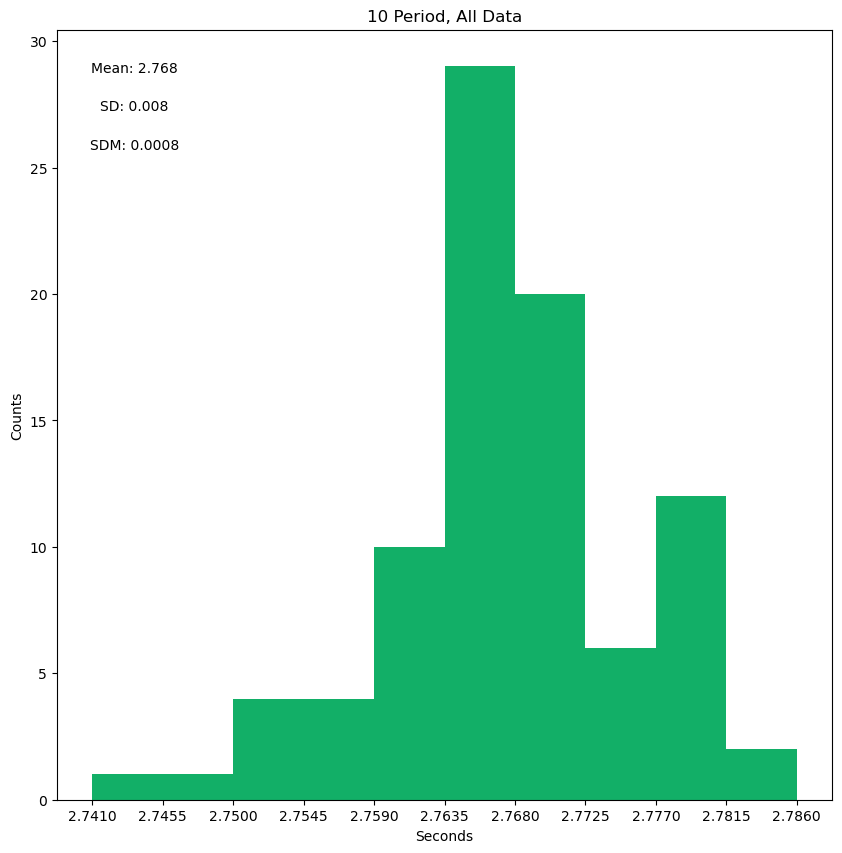

In [8]:
#EXPERIMENTAL VALUES
#TEN TEN TOGETHER
flat_10 = []
for i in ten_ten_filt:
    for elem in i:
        flat_10.append(elem)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

n_bins2=10
bin_range = np.linspace(min(flat_10),max(flat_10), 10+1)

n, bins, pathces = plt.hist(flat_10, n_bins2, color='#12af67')

plt.xticks(bin_range)

plt.text(.1, 0.95, f'Mean: {np.round(np.mean(flat_10),3)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.1, 0.9, f'SD: {np.round(ssd(flat_10),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.1, 0.85, f'SDM: {np.round(ssd(flat_10)/np.sqrt(len(flat_10)),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.title('10 Period, All Data')
plt.xlabel('Seconds')
plt.ylabel('Counts')
plt.show()

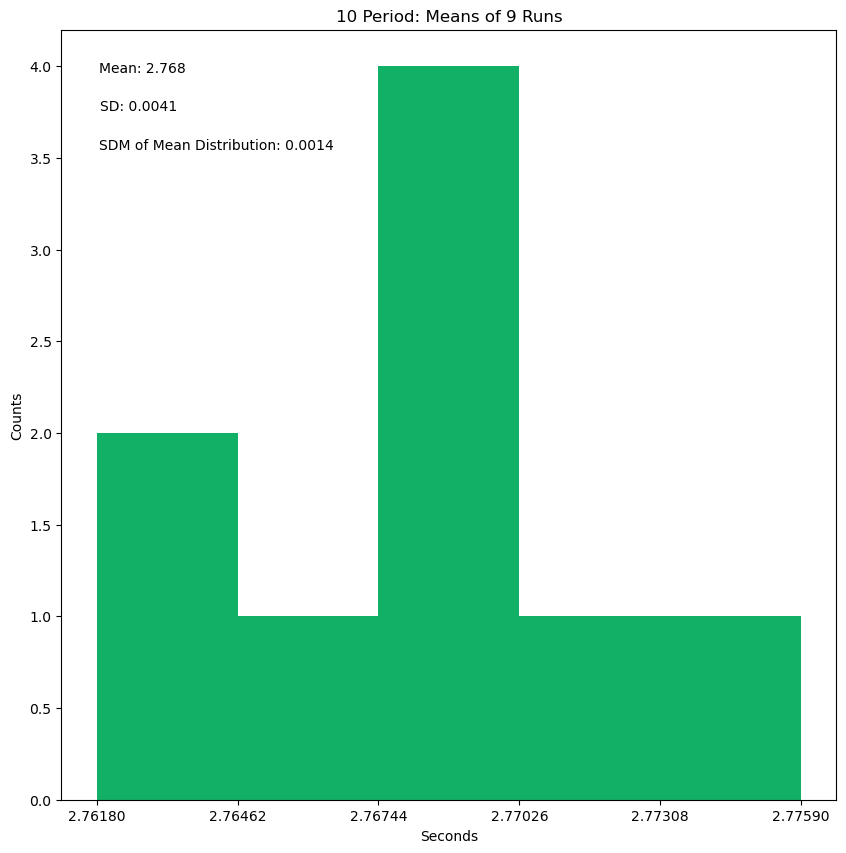

In [9]:
#EXPERIMENTAL VALUES
#TEN TEN hist of means

ten_ten_means = [np.mean(i) for i in ten_ten_filt]
ten_ten_ssd = [ssd(i) for i in ten_ten_filt]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
n_bins2=5
bin_range = np.linspace(min(ten_ten_means),max(ten_ten_means), 5+1)

n, bins, pathces = plt.hist(ten_ten_means, n_bins2, color='#12af67')

plt.xticks(bin_range)

plt.text(.105, 0.95, f'Mean: {np.round(np.mean(ten_ten_means),3)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.1, 0.9, f'SD: {np.round(ssd(ten_ten_means),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.2, 0.85, f'SDM of Mean Distribution: {np.round(ssd(ten_ten_means)/np.sqrt(len(ten_ten_means)),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.title(f'10 Period: Means of {len(ten_ten_means)} Runs')
plt.xlabel('Seconds')
plt.ylabel('Counts')
plt.show()

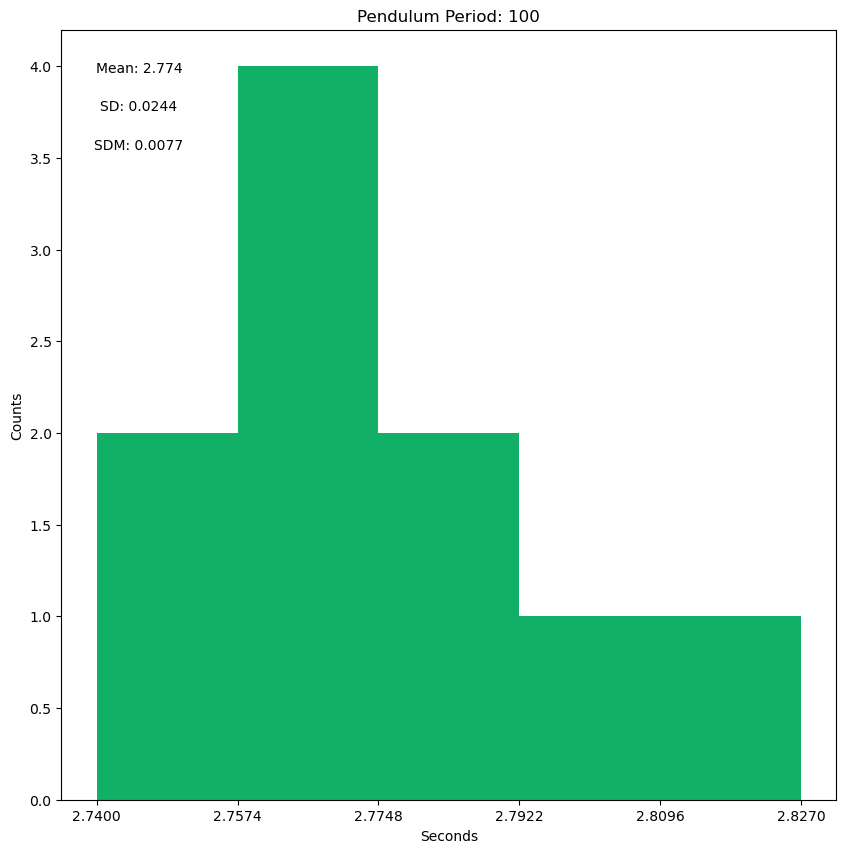

In [10]:
#EXPERIMENTAL VALUES
#HUNDRED TEN TIMES

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

n_bins2=5
bin_range = np.linspace(min(ten_hundred),max(ten_hundred), 5+1)
n, bins, pathces = plt.hist(ten_hundred, n_bins2, color='#12af67')
plt.xticks(bin_range)
plt.text(.1, 0.95, f'Mean: {np.round(np.mean(ten_hundred),3)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.1, 0.9, f'SD: {np.round(ssd(ten_hundred),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.1, 0.85, f'SDM: {np.round(ssd(ten_hundred)/np.sqrt(len(ten_hundred)),4)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.title(f'Pendulum Period: 100')
plt.xlabel('Seconds')
plt.ylabel('Counts')
plt.show()



In [11]:
#Looking at Z values

def z_val(theor, meas, theor_sdm, meas_sdm):
    return np.abs(theor-meas)/np.sqrt(meas_sdm**2 + theor_sdm**2)

Z_one_ten = z_val(acc_T.n, np.mean(ten_one), acc_T.s, ssd(ten_one)/np.sqrt(len(ten_one)))

Z_ten_ten = [z_val(acc_T.n, np.mean(i), acc_T.s, ssd(i)/np.sqrt(len(i))) for i in ten_ten]

Z_ten_hund = z_val(acc_T_hund.n, np.mean(ten_hundred), acc_T_hund.s, ssd(ten_hundred)/np.sqrt(len(ten_hundred)))

print(acc_T_hund.n, acc_T_hund.s)
print(Z_one_ten)
print(Z_ten_ten)
print(Z_ten_hund)


2.76 0.004
2.269442815630025
[0.8098355819311833, 0.0, 1.6307298299820727, 1.2153425600370305, 1.8163480488617716, 2.101904804564607, 2.6485521601336317, 2.9914518670957193, 4.124793828219442]
1.6220236151655758


In [12]:
#weighted means and standard deviations

ten_ten_weighted = wMean_wStd(ten_ten_means, ten_ten_ssd)
print(ten_ten_weighted)

one_ten_means = [np.mean(i) for i in ten_ten]+[np.mean(ten_one)]
one_ten_ssd = ten_ten_ssd + [ssd(ten_one)]
one_ten_weighted = wMean_wStd(one_ten_means,one_ten_ssd)
print(one_ten_weighted)

print(acc_T)

(2.7686911228544417, 0.0019228407797134805)
(2.7680210500486413, 0.0019225582514049977)
2.758+/-0.004
